###### *UF Audio Engineering Society*
Jackson Cornell, Justin Broce,  Eric Barkuloo


# **Feature Engineering**


###Loading libraries

In [1]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

###Loading data

In [2]:
!git clone https://github.com/aesuf/orchestral_samples

Cloning into 'orchestral_samples'...
remote: Enumerating objects: 11629, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 11629 (delta 8), reused 22 (delta 2), pack-reused 11589
Receiving objects: 100% (11629/11629), 1.28 GiB | 27.96 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Checking out files: 100% (11319/11319), done.


##Feature Extraction


In [3]:
#@title helper functions

#We take the first n seconds of the audio. If the audio is too short, we append zeros.

def trim_sample(y,sr,seconds):
  return librosa.util.fix_length(y,size=int((sr*seconds)))


def get_filenames():
  #files is a list of the names of all of our downloaded files
  files = os.listdir('orchestral_samples/data')
  """
  files[0] might look like 'bass-clarinet_Fs3_15_pianissimo_normal.wav'
  so we append 'orchestral_samples/data' to the start of every file
  so we can load it easier
  """
  return list(
      map(
      lambda file: 'orchestral_samples/data/' + file , files)
  )

##loading the names of all of our files from our downloaded data

In [4]:
files = get_filenames()
print('number of samples: ', len(files))
print('example file name: ', files[3000])

number of samples:  11318
example file name:  orchestral_samples/data/tuba_Gs2_05_mezzo-piano_mute.wav


Function to extract mel melspectrogram from a sample

In [5]:
def extract_mel(y,sr):
  y = trim_sample(y,sr,1.5) #we are looking at the first 15 seconds of each sample
  hop_length = 512
  n_fft = 255
  n_mfcc=128
  return librosa.feature.melspectrogram(y, n_fft=n_fft,hop_length=hop_length);

Function to plot melspectrogram

In [6]:
def plot_mel(melspec,sr=22050,hop_length=512):
  fig, ax = plt.subplots(figsize=(20,7))
  librosa.display.specshow(melspec,sr=sr, cmap='cool',hop_length=hop_length)
  ax.set_xlabel('Time', fontsize=15)
  ax.set_title('MelSpectrogram', size=20)
  plt.colorbar()
  plt.show()





Creating a feature array of the right dimension, at with entry populated with zeroes

In [7]:
mel_dims = extract_mel(*librosa.load(files[1])).shape;
features = np.zeros((len(files),mel_dims[0],mel_dims[1]))
print('\ndimensions of our features array:', features.shape)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "



dimensions of our features array: (11318, 128, 65)


We populate each ith element of features with a
mel spectrogram of each file.

*Warning: this is extremly slow and takes around 15 minutes*


Maybe take a coffee break in the meanwhile

In [8]:

i = 0
for file in files:
  features[i] = extract_mel(*librosa.load(file,duration=1.5))
  i = i+1
  if i%1000==0:
    print("sample: ", i)
  


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


sample:  1000
sample:  2000
sample:  3000
sample:  4000
sample:  5000
sample:  6000
sample:  7000
sample:  8000
sample:  9000
sample:  10000
sample:  11000


Now we have features array of dim `(11318, 128, 65)`
where each `features[i]` corresponds to the mel spectrogram of the file: `files[i]`

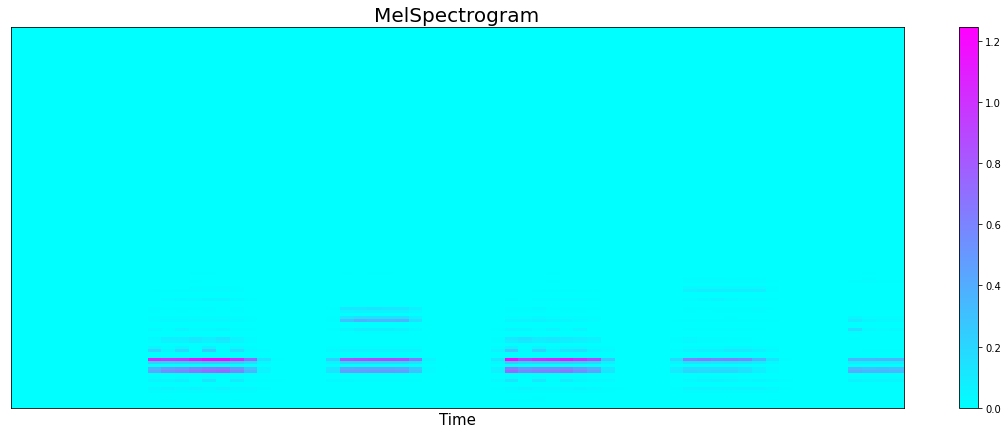

orchestral_samples/data/bassoon_G3_phrase_mezzo-forte_tongued-slur.wav


In [13]:

plot_mel(features[15])
print(files[15])

We can save the `features` np array so we don't have to worry about computing it again. Warning: I have not beem able to upload this to github and download to google colab successfully. It may work on your local computer, but I ran into a bunc of issues, so you should problably not worry about this 

In [ ]:
np.save('x_data',features)

## **Getting the Y values, and labels**


In [14]:
#@title helper functions
def get_instruments():
  instruments = {
  "bass-clarinet": 0,
  "contrabassoon": 1,
  "cello": 2,
  "clarinet": 3,
  "bassoon": 4,
  "double-bass": 5,
  "french-horn": 6,
  "guitar": 7,
  "mandolin": 8,
  "oboe": 9,
  "saxophone": 10,
  "trombone": 11,
  "trumpet": 12,
  "tuba": 13,
  "viola": 14,
  "violin": 15,
  
   #instruments is a python dictionary
  #read more at https://www.w3schools.com/python/python_dictionaries.asp
  #similiar to a hashmap, or c++'s ordered_map
}
  return instruments


"""
This function will return the instrument class value given the filename ie
get_y_val('cello_Gs2_05_pianissimo_arco-normal.wav')
  returns 2

And get_y_val(double-bass_D2_1_pianissimo_arco-normal.wav)
returns 5

"""
def get_y_value(file):
  instruments = get_instruments()
  for instrument in instruments:
    #string.find(foo) returns the first occurence of foo,
    # and -1 if foo is not in the string.
    if file.find(instrument)!=-1:
      return instruments[instrument]
  return "NULL"

def get_y_values():
  #loading the names of the files in /data to a list
  files = os.listdir('orchestral_samples/data')
  """
  map(f,iterable) will apply functiion f to each element in iterable container.
  In this case we are applying the function get_y_value, 
  to every element in files. List will turn a map object into a list,
   and then we can turn the list into a numpy array
  """
  return np.array(
      list(
          map(get_y_value,files)
          )
      )
  
"""
 generates numpy array that maps indices to instruments
 ie get_labels()[3] returns 'clarinet'
"""
def get_labels():
  inv_map = {v: k for k, v in get_instruments().items()}
  return np.array(list(inv_map.items()))[:,[1]]


Making sure that we have to same amount of y values as inputs, and making sure that the classes are correct, and that there are no null entries

In [18]:

files = os.listdir('orchestral_samples/data')
y_data = get_y_values()
labels = get_labels()
print(
    f"""
    y_test length: {y_data.size}
    number of files: {len(files)}
    """
)
for i in range(1,10):
  print(f"""
    y_value : {labels[y_data[i]]}
    filename : {files[i]}
    """)
print(np.unique(y_data))
labels = labels[:,0]


    y_test length: 11318
    number of files: 11318
    

    y_value : ['clarinet']
    filename : clarinet_D4_025_piano_normal.wav
    

    y_value : ['cello']
    filename : cello_F2_phrase_mezzo-forte_arco-legato.wav
    

    y_value : ['oboe']
    filename : oboe_B5_05_piano_normal.wav
    

    y_value : ['bassoon']
    filename : bassoon_D2_05_piano_normal.wav
    

    y_value : ['double-bass']
    filename : double-bass_Ds2_05_mezzo-forte_arco-normal.wav
    

    y_value : ['contrabassoon']
    filename : contrabassoon_F1_1_piano_normal.wav
    

    y_value : ['trombone']
    filename : trombone_C5_15_pianissimo_normal.wav
    

    y_value : ['cello']
    filename : cello_As4_15_mezzo-piano_arco-normal.wav
    

    y_value : ['bass-clarinet']
    filename : bass-clarinet_Fs3_05_forte_normal.wav
    
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


# **Test Train Split etc:** 

*finally we will have data in a format that can be fed into models*

Importing stuff:

In [24]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical # it's red but okay

##Performing test/train split:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    features, y_data, test_size=0.33, random_state=42)

X train and test are the spectrograms

Y train and test are the what instruments the samples are

In [29]:
print(f"""
X_train dims: {X_train.shape}
X_test dims: {X_test.shape}
Y_train dims: {y_train.shape}
Y_test dims: {y_test.shape}
"""
)


X_train dims: (7583, 128, 65)
X_test dims: (3735, 128, 65)
Y_train dims: (7583,)
Y_test dims: (3735,)



In [30]:
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

What is y_train_cat ?? :

In [38]:
print(y_train[0])
print(y_train_cat[0])

4
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


If you want to know what instrument a sample is by y_value:

In [41]:
print(y_train_cat.shape)
print(labels[np.argmax(y_train_cat)])
print(y_train.shape)
print(labels[y_train[0]])

(7583, 16)
bassoon
(7583,)
bassoon


## Normalizing values to be between 0 and 1:

In [42]:
max_ = max(np.max(X_test),np.max(X_train))
print(max_)

61.81525802612305


In [43]:
max_ = max(np.max(X_test),np.max(X_train))
X_test = X_test/max_
X_train = X_train/max_

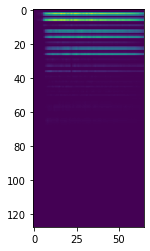

In [48]:
plt.imshow(X_train[100])

# okay great, now we can make like a model
*todo: replace this bad model with a not-bad model*

In [81]:
model = keras.models.Sequential()

model.add(keras.Input(shape=(128,65)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation = 'relu', use_bias=False))
model.add(keras.layers.Dense(512, activation = 'relu', use_bias=False)) 
#model.add(keras.layers.Dense("who do we appreciate", activation = 'relu', use_bias=False))
model.add(keras.layers.Dense(16, activation='softmax', use_bias=False)) 

In [82]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [83]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 8320)              0         
                                                                 
 dense_23 (Dense)            (None, 128)               1064960   
                                                                 
 dense_24 (Dense)            (None, 512)               65536     
                                                                 
 dense_25 (Dense)            (None, 16)                8192      
                                                                 
Total params: 1,138,688
Trainable params: 1,138,688
Non-trainable params: 0
_________________________________________________________________


In [84]:
h = model.fit(X_train, y_train_cat, 
          batch_size =250, epochs = 5,
          validation_data = (X_test, y_test_cat)          
          )

Epoch 1/5
31/31 [==============================] - 2s 62ms/step - loss: 2.6640 - accuracy: 0.1263 - val_loss: 2.4849 - val_accuracy: 0.1483
Epoch 2/5
31/31 [==============================] - 1s 43ms/step - loss: 2.3981 - accuracy: 0.1888 - val_loss: 2.2962 - val_accuracy: 0.2203
Epoch 3/5
31/31 [==============================] - 1s 42ms/step - loss: 2.2431 - accuracy: 0.2498 - val_loss: 2.1717 - val_accuracy: 0.3052
Epoch 4/5
31/31 [==============================] - 1s 42ms/step - loss: 2.1252 - accuracy: 0.2988 - val_loss: 2.0850 - val_accuracy: 0.3108
Epoch 5/5
31/31 [==============================] - 1s 41ms/step - loss: 2.0344 - accuracy: 0.3389 - val_loss: 2.0157 - val_accuracy: 0.3341


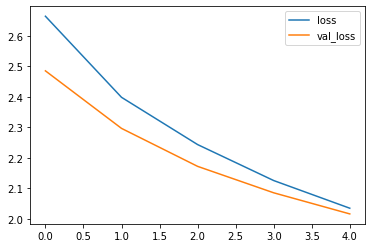

In [85]:
plt.plot(h.history['loss'], label = 'loss')
plt.plot(h.history['val_loss'], label = 'val_loss')
plt.legend()

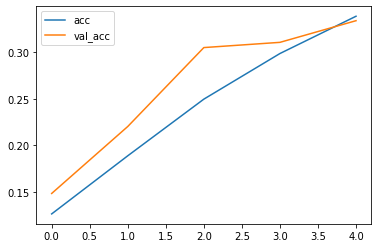

In [86]:
plt.plot(h.history['accuracy'], label = 'acc')
plt.plot(h.history['val_accuracy'], label = 'val_acc')
plt.legend()